# Chapter 2. Neural Modeling and Analysis: Exercise
Exercise Author: Bach Nguyen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint, ode

### Draw the F-I curve for the H-H model.

In [2]:
# Sodium channel acitivation gate
def alpha_m(v):
    # sodium activation gate opening rate
    return 0.1*(v+40)/(1-np.exp(-(v+40)/10))
def beta_m(v):
    # sodium activation gate closing rate
    return 4*np.exp(-(v+65)/18)
def m_inf(v):
    # equilibrium activation: alpha_m*(1-m) - beta_m*m = 0
    return alpha_m(v)/(alpha_m(v) + beta_m(v))

In [3]:
# Sodium channel inacitivation gate
def alpha_h(v):
    # sodium inactivation gate opening rate
    return 0.07*np.exp(-(v+65)/20)
def beta_h(v):
    # sodium inactivation gate closing rate
    return 1/(1+np.exp(-(v+35)/10))
def h_inf(v):
    # equilibrium inactivation: alpha_h*(1-h) - beta_h*h = 0
    return alpha_h(v)/(alpha_h(v) + beta_h(v))

In [4]:
# Potassium channel acitivation gate
def alpha_n(v):
    # sodium activation gate opening rate
    return 0.01*(v+55)/(1-np.exp(-(v+55)/10))
def beta_n(v):
    # sodium activation gate closing rate
    return 0.125*np.exp(-(v+65)/80)
def n_inf(v):
    # equilibrium activation: alpha_n*(1-n) - beta_n*n = 0
    return alpha_n(v)/(alpha_n(v) + beta_n(v))

In [5]:
# HH: Hodgkin-Huxley (1952) model
C = 1.    # membrane capacitance (uF/cm^2)
# maximum conductances (uS/cm^2)
gna = 120.  # sodium
gk = 36.    # potassium
gl = 0.3   # leak
# reversal potentials (mV)
Ena = 50.   # sodium
Ek = -77.   # potassium
El = -54.4 # leak
def hh(t, y, stim=0.):    
    # state variables: potential and activation/inactivation
    v, m, h, n = y
    # membrane potential
    if callable(stim):
        I = stim(t)  # time-dependent
    else:
        I = stim  # constant
    dv = (gna*m**3*h*(Ena-v) + gk*n**4*(Ek-v) + gl*(El-v) + I)/C
    # sodium current activation
    dm = alpha_m(v)*(1-m) - beta_m(v)*m
    # sodium current inactivation
    dh = alpha_h(v)*(1-h) - beta_h(v)*h
    # potassium current activation
    dn = alpha_n(v)*(1-n) - beta_n(v)*n
    return [ dv, dm, dh, dn]

In [6]:
Vth = -40  # threshold potential

def hhspikes(Ic):  # spike times with constant current
    y0 = [ -70, 0.1, 0.6, 0.4]
    hhs = ode(hh).set_integrator('dopri5')
    hhs.set_f_params(Ic)  # stimulus
    hhs.set_initial_value(y0, 0)
    tinit = 200  # initial transient
    trun = 1000  # for 1000ms
    dt = 1
    tf = []  # spike timing
    while hhs.successful() and hhs.t <= tinit+trun:
        v = hhs.integrate(hhs.t+dt)  # step
        if v[0] >= Vth:  # threshold reached
            hhs.set_initial_value(y0, hhs.t)  # reset V
            if hhs.t>=tinit:  # after transient
                tf.append(hhs.t)
    return np.array(tf)

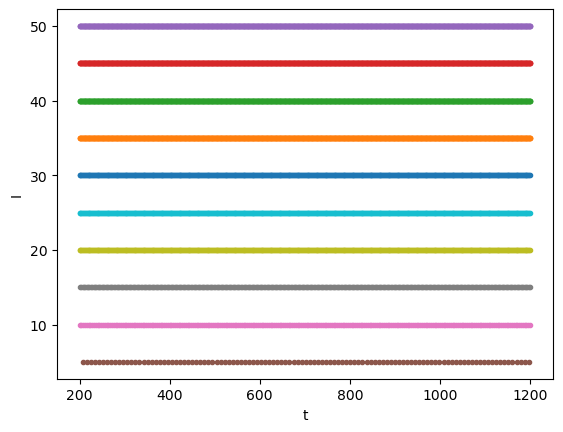

In [7]:
Is = np.arange(-20, 51, 5)
Fs = []
for c, Ic in enumerate(Is):
    tf = hhspikes(Ic)
    plt.plot(tf, tf*0+Ic, '.')
    Fs.append(len(tf))
plt.xlabel("t")
plt.ylabel("I");
plt.show()

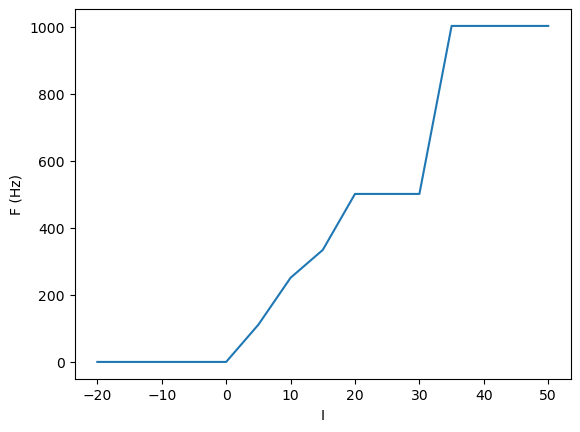

In [8]:
plt.plot(Is, Fs);
plt.xlabel("I")
plt.ylabel("F (Hz)");
plt.show()

### Run a network of IF neurons with simple pulse-connection instead of $\alpha$ function.

In [21]:
# IaF neuron network with alpha function synapses
#I = 0   # bias current
# Iaf neurons
N = 10  # number of neurons
tau = 50  # cellular time constant
V0 = -45  # resting near threshold
Vth = -40  # threshold
Vs = 40  # spike height
Vr = -80  # reset
# Alpha synapses
taus = 5  # synaptic time constant
W = 40   # connection weight size; assume exponential distribution
w = np.random.exponential(W, N**2).reshape((N,N))
for i in range(N):
    w[i,i] = 0  # remove self-connection

In [22]:
def integnet(t, vu):  # integrate
    # vu = [v, u]
    v = vu[:N]
    u = vu[N:].reshape((N,N,2))
    # synaptic potential
    epsp = np.sum(w*u[:,:,1], axis=1)  # sum rows
    # membrane dynamics
    dv = (-v + V0 + epsp)/tau
    # synaptic dynamics: for uniform taus, it can be reduced to N dim
    du = np.stack((-u[:,:,0]/taus, (u[:,:,0]-u[:,:,1])/taus), axis=2)
    return np.concatenate([dv, du.flatten()])
def firenet(t, vu):  # fire
    return (-1 if sum(vu[:N]>=Vth) else 0)  # stop if any of v>=V1

In [23]:
# Run a network simulation
iafnet = ode(integnet).set_integrator('dopri5')
iafnet.set_solout(firenet)  # stop when threshold is reached
v0 = np.random.uniform(Vr, Vth, N)  # initial state
u0 = np.random.uniform(0, 1, N*N*2)  # synapse state
iafnet.set_initial_value(np.append(v0, u0, 0))
V = [v0]
T = [0]
tend = 500
dt = 1
while iafnet.successful() and iafnet.t <= tend:
    vu = iafnet.integrate(iafnet.t+dt)  # new v and u
    V.append(vu[:N].copy())   # record V
    T.append(iafnet.t)    # record t
    if sum(vu[:N] >= Vth):  # any reached threshold
        for i in range(N):   # check each neuron
            if vu[i] >= Vth:  # reached threshold
                vu[i] = Vr   # reset potential
                vu[N:].reshape(N,N,2)[:,i,0] += 1  # synaptic input
                V[-1][i] = Vs  # spike
        iafnet.set_initial_value(vu, iafnet.t)  # reset state
V = np.array(V)   # list to array

In [24]:
# Simple pulse-connection implementation (replacing alpha function synapses)
# In this version, synaptic inputs are instantaneous pulses rather than shaped waveforms

def integnet_pulse(t, v_pulse):  # integrate with pulse-connection
    # v_pulse = [v, pulse_inputs]
    v = v_pulse[:N]
    pulse_inputs = v_pulse[N:N*2]  # Current pulse inputs to each neuron
    
    # synaptic potential from instantaneous pulses
    epsp = pulse_inputs  # Direct application of pulse inputs
    
    # membrane dynamics
    dv = (-v + V0 + epsp)/tau
    
    # pulse inputs decay quickly (exponential decay with fast time constant)
    dpulse = -pulse_inputs / 2.0  # Fast decay, adjust time constant as needed
    
    return np.concatenate([dv, dpulse])

def firenet_pulse(t, v_pulse):  # fire detection for pulse version
    return (-1 if sum(v_pulse[:N]>=Vth) else 0)  # stop if any of v>=Vth

In [25]:
# Run a network simulation with simple pulse-connection
iafnet_pulse = ode(integnet_pulse).set_integrator('dopri5')
iafnet_pulse.set_solout(firenet_pulse)  # stop when threshold is reached

v0 = np.random.uniform(Vr, Vth, N)  # initial membrane potentials
pulse0 = np.zeros(N)  # initial pulse inputs (all zero)
iafnet_pulse.set_initial_value(np.append(v0, pulse0), 0)

V_pulse = [v0.copy()]
T_pulse = [0]
tend = 300
dt = 1

noise_std = 0.5  # Standard deviation of noise current

print(f"Starting pulse-connection simulation for {tend} ms...")

while iafnet_pulse.successful() and iafnet_pulse.t <= tend:
    v_pulse_new = iafnet_pulse.integrate(iafnet_pulse.t + dt)
    
    # Add small random noise to membrane potentials
    noise = np.random.normal(0, noise_std, N)
    v_pulse_new[:N] += noise
    
    V_pulse.append(v_pulse_new[:N].copy())   # record V
    T_pulse.append(iafnet_pulse.t)    # record t
    
    if sum(v_pulse_new[:N] >= Vth):  # any reached threshold
        for i in range(N):   # check each neuron
            if v_pulse_new[i] >= Vth:  # reached threshold
                v_pulse_new[i] = Vr   # reset potential
                # Apply instantaneous pulse to all postsynaptic neurons
                for j in range(N):
                    if i != j:  # don't connect to self
                        v_pulse_new[N + j] += w[j, i]  # Use lowercase w instead of W
                V_pulse[-1][i] = Vs  # record spike for plotting
        iafnet_pulse.set_initial_value(v_pulse_new, iafnet_pulse.t)  # reset state

V_pulse = np.array(V_pulse)   # list to array
print(f"Pulse-connection simulation completed. Final shape: {V_pulse.shape}")


Starting pulse-connection simulation for 300 ms...
Pulse-connection simulation completed. Final shape: (303, 10)


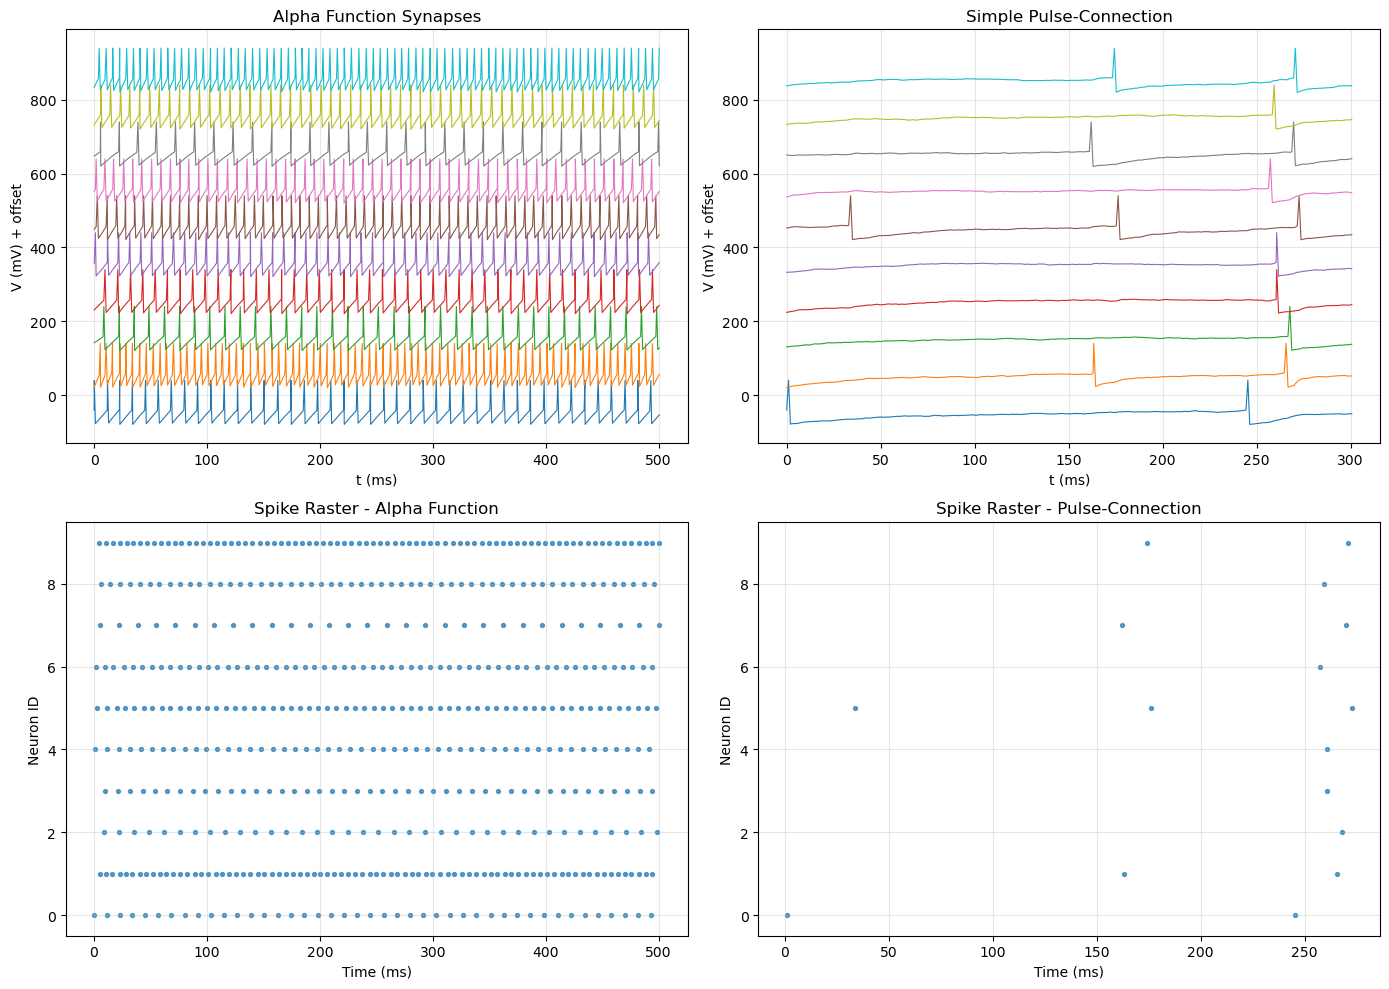

Alpha function spikes: 541
Pulse-connection spikes: 16


In [26]:
# Compare alpha function vs pulse-connection results
plt.figure(figsize=(14, 10))

# Plot alpha function results
plt.subplot(2, 2, 1)
for i in range(N):
    plt.plot(T, V[:, i] + i*100, linewidth=0.8)
plt.xlabel('t (ms)')
plt.ylabel('V (mV) + offset')
plt.title('Alpha Function Synapses')
plt.grid(True, alpha=0.3)

# Plot pulse-connection results
plt.subplot(2, 2, 2)
for i in range(N):
    plt.plot(T_pulse, V_pulse[:, i] + i*100, linewidth=0.8)
plt.xlabel('t (ms)')
plt.ylabel('V (mV) + offset')
plt.title('Simple Pulse-Connection')
plt.grid(True, alpha=0.3)

# Raster plot for alpha function
plt.subplot(2, 2, 3)
spike_times_alpha = []
spike_neurons_alpha = []
for t_idx, t_val in enumerate(T):
    for n_idx in range(N):
        if V[t_idx, n_idx] > 0:  # spike detected
            spike_times_alpha.append(t_val)
            spike_neurons_alpha.append(n_idx)

plt.scatter(spike_times_alpha, spike_neurons_alpha, s=8, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID')
plt.title('Spike Raster - Alpha Function')
plt.ylim(-0.5, N-0.5)
plt.grid(True, alpha=0.3)

# Raster plot for pulse-connection
plt.subplot(2, 2, 4)
spike_times_pulse = []
spike_neurons_pulse = []
for t_idx, t_val in enumerate(T_pulse):
    for n_idx in range(N):
        if V_pulse[t_idx, n_idx] > 0:  # spike detected
            spike_times_pulse.append(t_val)
            spike_neurons_pulse.append(n_idx)

plt.scatter(spike_times_pulse, spike_neurons_pulse, s=8, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID')
plt.title('Spike Raster - Pulse-Connection')
plt.ylim(-0.5, N-0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Alpha function spikes: {len(spike_times_alpha)}")
print(f"Pulse-connection spikes: {len(spike_times_pulse)}")

### Simulate an artificial recurrent neural network and see the behaviors with different connection weights.

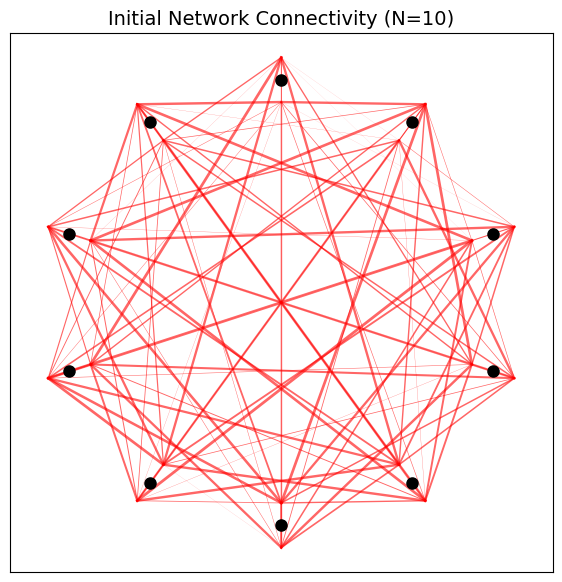

In [15]:
# IaF neuron network with alpha function synapses
#I = 0   # bias current
# Iaf neurons
N = 10  # number of neurons
tau = 50  # cellular time constant
V0 = -45  # resting near threshold
Vth = -40  # threshold
Vs = 40  # spike height
Vr = -80  # reset
# Alpha synapses
W = 40
taus = 5  # synaptic time constant

# The code below re-initializes W with random weights.
# W = np.random.exponential(W, N**2).reshape((N,N))

# W = np.random.normal(0, W, N**2).reshape((N,N))
W = np.random.uniform(1, 100, N**2).reshape((N,N))
# W = np.random.laplace(0, W, N**2).reshape((N,N))

# _i_for_pos_calc is used for neuron positions, based on the placeholder's 'i = np.arange(0,n)'
_i_for_pos_calc = np.arange(0,N) 
pos = np.array([np.sin(2*np.pi*_i_for_pos_calc/N), np.cos(2*np.pi*_i_for_pos_calc/N)]).T

# Normalize W for plotting line widths.
# Using np.abs(W) for normalization makes it robust for cases where W might contain negative values,
# though W in this specific cell is non-negative as it's generated by np.random.exponential.
max_abs_W = np.max(np.abs(W))

# Plotting parameters
line_width_scale_factor = 2.0  # Scales the normalized line width
min_weight_threshold = 1e-6    # Weights below this (in magnitude) are considered zero for plotting
min_linewidth_threshold = 1e-3 # Lines thinner than this won't be plotted

plt.figure(figsize=(7, 7))  # Set figure size for better visualization

# Plot neuron positions as black circles
plt.plot(pos[:, 0], pos[:, 1], 'ko', markersize=8, zorder=2)

# W[i,j] represents the connection strength from neuron j (source) to neuron i (target).
for i in range(N):  # Iterate over target neurons
    for j in range(N):  # Iterate over source neurons
        weight = W[i, j]

        # Only plot connections with significant weight
        if np.abs(weight) > min_weight_threshold:
            # Calculate normalized absolute strength (value between 0 and 1)
            normalized_abs_strength = (np.abs(weight) / max_abs_W) if max_abs_W > 0 else 0
            
            # Scale the line width
            line_width = line_width_scale_factor * normalized_abs_strength

            # Plot the line if it's visibly thick enough
            if line_width > min_linewidth_threshold:
                # Determine color based on weight sign (as in the original placeholder)
                connection_color = 'r' if weight > 0 else 'b'
                
                # Plot the connection line from neuron j to neuron i.
                plt.plot(pos[[j, i], 0] * [0.9, 1.1], pos[[j, i], 1] * [0.9, 1.1],
                         lw=line_width, color=connection_color, alpha=0.6, zorder=1)

plt.axis('equal')  # Ensures the circular layout of neurons appears as a circle.
plt.xticks([])     # Remove x-axis ticks and labels.
plt.yticks([])     # Remove y-axis ticks and labels.
plt.title(f"Initial Network Connectivity (N={N})", fontsize=14)
plt.show()

In [16]:
def integnet(t, vu):  # integrate
    # vu = [v, u]
    v = vu[:N]
    u = vu[N:].reshape((N,N,2))
    # synaptic potential
    epsp = np.sum(W*u[:,:,1], axis=1)  # sum rows
    # membrane dynamics
    dv = (-v + V0 + epsp)/tau
    # synaptic dynamics: for uniform taus, it can be reduced to N dim
    du = np.stack((-u[:,:,0]/taus, (u[:,:,0]-u[:,:,1])/taus), axis=2)
    return np.concatenate([dv, du.flatten()])
def firenet(t, vu):  # fire
    return (-1 if sum(vu[:N]>=Vth) else 0)  # stop if any of v>=V1

In [17]:
# Run a network simulation
iafnet = ode(integnet).set_integrator('dopri5')
iafnet.set_solout(firenet)  # stop when threshold is reached
v0 = np.random.uniform(Vr, Vth, N)  # initial state
u0 = np.random.uniform(0, 1, N*N*2)  # synapse state
iafnet.set_initial_value(np.append(v0, u0, 0))
V = [v0]
T = [0]
tend = 300
dt = 1
while iafnet.successful() and iafnet.t <= tend:
    vu = iafnet.integrate(iafnet.t+dt)  # new v and u
    V.append(vu[:N].copy())   # record V
    T.append(iafnet.t)    # record t
    if sum(vu[:N] >= Vth):  # any reached threshold
        for i in range(N):   # check each neuron
            if vu[i] >= Vth:  # reached threshold
                vu[i] = Vr   # reset potential
                vu[N:].reshape(N,N,2)[:,i,0] += 1  # synaptic input
                V[-1][i] = Vs  # spike
        iafnet.set_initial_value(vu, iafnet.t)  # reset state
V = np.array(V)   # list to array

In [18]:
V.shape

(503, 10)

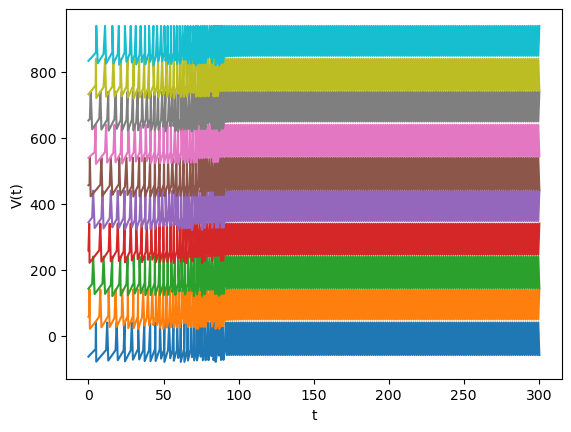

In [19]:
plt.plot(T, V + np.arange(N)*100)  # shift traces vertically
plt.xlabel("t")
plt.ylabel("V(t)")
plt.show()

### Implement Hebbian or STDP rule in the above network model and see how the network behavior and weights evolve with plasticity. 

Starting simulation with STDP for 1000 ms...
Simulation finished.


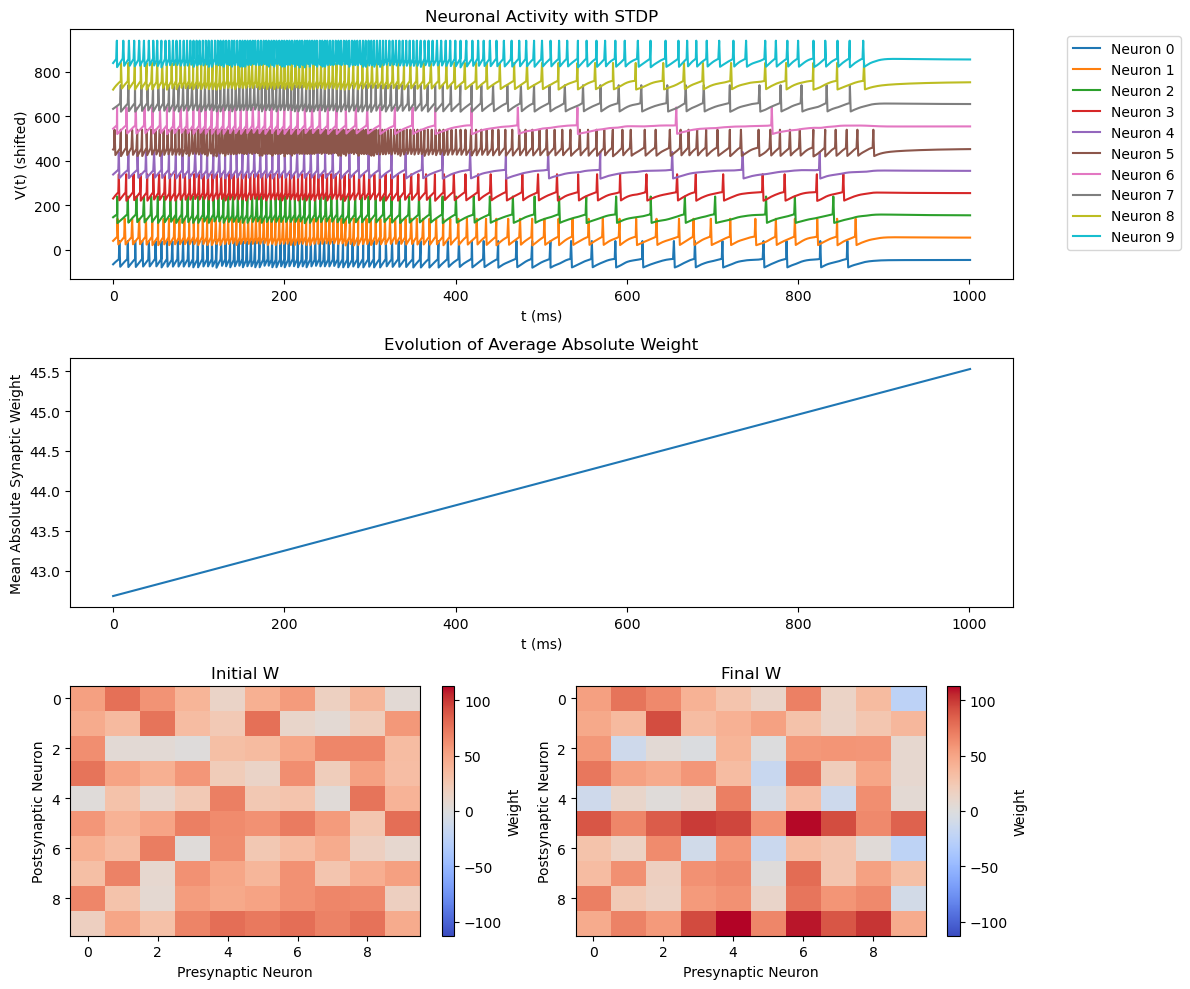

In [20]:
# STDP parameters
tau_stdp = 10.0  # ms, time constant for STDP window
eta = 0.5      # Learning rate
A_plus = 2.0     # Amplitude for LTP
A_minus = 2.0    # Amplitude for LTD (absolute value)

# Initialize last spike times for all neurons
last_spike_times = np.full(N, -np.inf)  # Using -np.inf for neurons that haven't spiked yet

# Store W history for plotting
current_W = np.random.uniform(1, 80, N**2).reshape((N,N))
W_history = [current_W.copy()]
T_W_update = [0] # Times at which W is recorded

# Re-initialize simulation
iafnet = ode(integnet).set_integrator('dopri5')
iafnet.set_solout(firenet)  # stop when threshold is reached

# Use W for the global W in integnet
W = current_W 

v0 = np.random.uniform(Vr, Vth, N)  # initial state for V
u0 = np.random.uniform(0, 1, N*N*2)  # initial state for u (synaptic variables)
iafnet.set_initial_value(np.append(v0, u0), 0) # t=0

V_stdp = [v0.copy()] # List to store voltage traces
T_stdp = [0]      # List to store time points

tend = 1000  # Simulate for a longer time to see STDP effects
dt = 1

print(f"Starting simulation with STDP for {tend} ms...")

while iafnet.successful() and iafnet.t < tend:
    time_next_step = iafnet.t + dt
    vu_new = iafnet.integrate(time_next_step)
    
    V_stdp.append(vu_new[:N].copy())
    T_stdp.append(iafnet.t)

    if np.any(vu_new[:N] >= Vth):  # If any neuron reached threshold
        current_time = iafnet.t
        spiked_neuron_indices = np.where(vu_new[:N] >= Vth)[0]

        temp_W_updates = np.zeros_like(current_W)

        for k_idx in spiked_neuron_indices: # k_idx is the neuron that just spiked
            # Update synapses connected to neuron k_idx
            for j_idx in range(N):
                if k_idx == j_idx:
                    continue

                # 1. k_idx is postsynaptic, j_idx is presynaptic (update W[k_idx, j_idx])
                if last_spike_times[j_idx] > -np.inf: # Check if presynaptic j_idx has spiked before
                    delta_t = current_time - last_spike_times[j_idx]
                    if delta_t > 0: # LTP: pre-before-post
                        dw = A_plus * np.exp(-delta_t / tau_stdp)
                        temp_W_updates[k_idx, j_idx] += eta * dw
                    elif delta_t < 0: # LTD: post-before-pre
                        dw = -A_minus * np.exp(delta_t / tau_stdp) # delta_t is negative
                        temp_W_updates[k_idx, j_idx] += eta * dw
                
                # 2. k_idx is presynaptic, j_idx is postsynaptic (update W[j_idx, k_idx])
                if last_spike_times[j_idx] > -np.inf: # Check if postsynaptic j_idx has spiked before
                    delta_t = last_spike_times[j_idx] - current_time # t_post (j_idx) - t_pre (k_idx)
                    if delta_t > 0: # LTP: pre-before-post (k_idx fired before j_idx's last spike)
                        dw = A_plus * np.exp(-delta_t / tau_stdp)
                        temp_W_updates[j_idx, k_idx] += eta * dw
                    elif delta_t < 0: # LTD: post-before-pre (j_idx's last spike was before k_idx fired)
                        dw = -A_minus * np.exp(delta_t / tau_stdp) # delta_t is negative
                        temp_W_updates[j_idx, k_idx] += eta * dw
            
            # Update last spike time for the neuron that just fired
            last_spike_times[k_idx] = current_time

        current_W += temp_W_updates # This modifies current_W, and since W points to current_W, global W is modified.
        # current_W = np.clip(current_W, -max_abs_W, max_abs_W)


        # Resetting neurons (original logic from cell 18)
        for k_idx in spiked_neuron_indices:
            vu_new[k_idx] = Vr   # reset potential
            # Access 'u' part of vu_new correctly: vu_new[N:] is a flat array
            u_reshaped = vu_new[N:].reshape(N,N,2)
            u_reshaped[:,k_idx,0] += 1  # synaptic input to neurons postsynaptic to k_idx
            # V_stdp[-1] is the state *before* reset, V_stdp[-1][k_idx] is Vth or slightly above.
            # Set to Vs for plotting spike.
            V_stdp[-1][k_idx] = Vs 
        
        iafnet.set_initial_value(vu_new, current_time)

    if iafnet.t % 50 == 0 or iafnet.t >= tend : # Record W at intervals or at the end
        W_history.append(current_W.copy())
        T_W_update.append(iafnet.t)

V_stdp = np.array(V_stdp)
W_history = np.array(W_history)

print("Simulation finished.")

# Plotting results
plt.figure(figsize=(12, 10))

# 1. Plot voltage traces
plt.subplot(3, 1, 1)
for i in range(N):
    plt.plot(T_stdp, V_stdp[:, i] + i * 100, label=f'Neuron {i}' if N <= 10 else None)
plt.xlabel("t (ms)")
plt.ylabel("V(t) (shifted)")
plt.title("Neuronal Activity with STDP")
if N <= 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Plot average absolute weight change
plt.subplot(3, 1, 2)
avg_abs_W = np.mean(np.abs(W_history), axis=(1,2))
plt.plot(T_W_update, avg_abs_W)
plt.xlabel("t (ms)")
plt.ylabel("Mean Absolute Synaptic Weight")
plt.title("Evolution of Average Absolute Weight")

# 3. Plot initial and final weight matrices
if W_history.shape[0] > 1:
    plt.subplot(3, 2, 5)
    plt.imshow(W_history[0], cmap='coolwarm', aspect='auto', vmin=-np.max(np.abs(W_history)), vmax=np.max(np.abs(W_history)))
    plt.colorbar(label="Weight")
    plt.title("Initial W")
    plt.xlabel("Presynaptic Neuron")
    plt.ylabel("Postsynaptic Neuron")

    plt.subplot(3, 2, 6)
    plt.imshow(W_history[-1], cmap='coolwarm', aspect='auto', vmin=-np.max(np.abs(W_history)), vmax=np.max(np.abs(W_history)))
    plt.colorbar(label="Weight")
    plt.title("Final W")
    plt.xlabel("Presynaptic Neuron")
    plt.ylabel("Postsynaptic Neuron")
else:
    plt.subplot(3,1,3)
    plt.imshow(W_history[0], cmap='coolwarm', aspect='auto')
    plt.colorbar(label="Weight")
    plt.title("Initial W (Final W if no updates)")


plt.tight_layout()
plt.show()